# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [1]:
try:
    # one of the ways to check if our notebook is running inside google colab
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/gmum/ml2025-26.git
    import sys
    sys.path.append('/content/ml2025-26/lab')

Cloning into 'ml2025-26'...
remote: Enumerating objects: 114, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 114 (delta 38), reused 107 (delta 33), pack-reused 0 (from 0)
Receiving objects: 100% (114/114), 12.71 MiB | 25.58 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

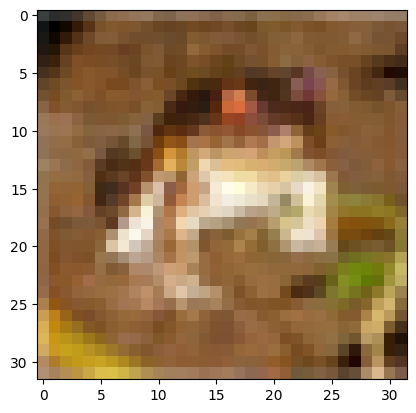

In [3]:
# data loading
if IN_COLAB:
    cifar_sample = np.load("/content/ml2025-26/lab/resources/cifar_sample.npy")
else:
    cifar_sample = np.load("resources/cifar_sample.npy")

# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = K $  

$ \hspace{140px} H_o =  \frac{H_i - F + 2P}{S} + 1  $

$ \hspace{140px} W_o = \frac{W_i - F + 2P}{S} + 1 $  

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?   

$ ( F \times F \times C_f + 1 ) \times K $

### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

![cnn.gif](https://raw.githubusercontent.com/gmum/ml2025-26/main/lab/resources/cnn.gif)

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli).

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [4]:
def convolution(image: torch.tensor,
                filters: torch.tensor,
                bias: torch.tensor,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param filters: torch.Tensor
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    n_filters, filter_channels, filter_size, filter_size = filters.shape
    # calculate the dimensions of the output image
    out_height = int((img_height - filter_size + 2 * padding) / stride) + 1
    out_width = int((img_width - filter_size + 2 * padding) / stride) + 1
    out_channels = n_filters
    conv_out = torch.empty((out_channels, out_height, out_width))
    padded_image = torch.tensor(np.pad(
    image,
    pad_width=((0, 0), (padding, padding), (padding, padding)),
    mode='constant',
    constant_values=0))

    for i_h in range(out_height):
      for i_w in range(out_width):
        h_start = stride * i_h
        w_start = stride * i_w
        fragment = padded_image[:, h_start:h_start+filter_size, w_start:w_start+filter_size]
        for n, filter in enumerate(filters):
          conv_element = torch.sum(fragment * filter)
          conv_out[n, i_h, i_w] = conv_element
        conv_out[:, i_h, i_w] = conv_out[:, i_h, i_w] + bias

    return conv_out

In [5]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [24]:
def max_pooling(image: torch.tensor,
                kernel_size: int,
                stride: int = 1,
                padding: int = 1):
    """
    :param image: torch.Tensor
        Input image of shape (C, H, W)
    :param kernel_size: int
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image
    """
    # get image dimensions
    img_channels, img_height, img_width = image.shape
    # your code here
    out_height = int((img_height - kernel_size + 2 * padding) / stride) + 1
    out_width = int((img_width - kernel_size + 2 * padding) / stride) + 1
    out_channels = img_channels
    conv_out = torch.empty((out_channels, out_height, out_width))
    padded_image = torch.tensor(np.pad(
    image,
    pad_width=((0, 0), (padding, padding), (padding, padding)),
    mode='constant',
    constant_values=0))

    for i_h in range(out_height):
      for i_w in range(out_width):
        h_start = stride * i_h
        w_start = stride * i_w
        fragment = padded_image[:, h_start:h_start+kernel_size, w_start:w_start+kernel_size]
        conv_out[:, i_h, i_w] = torch.max(fragment.reshape(fragment.size(0), -1), dim=1).values

    return conv_out

In [26]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

In [ ]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [ ]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module


In [ ]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

train_dataset = CIFAR10(root='.',
                        train=True,
                        download=True,
                        transform=???)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=???)


train_loader = DataLoader(train_dataset, batch_size=???, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

In [ ]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami


### Zadanie 4 ResNet (2 pkt.)

Zaimplementuj sieć konwolucyjną do klasyfikacji wieloklasowej na zbiorze CIFAR10 z blokami rezydualnymi.
```
Standard Block:  
x → Conv → ReLU → Conv → y  

Residual Block:  
x → Conv → BN → ReLU → Conv → BN → (+) → ReLU → y  
                         ↑  
                         x (identity lub projekcja)
```


In [ ]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module

In [ ]:
# Wykorzystaj pętlę uczenia z poprzedniego zadania

### Zadanie 5 Augmentacja danych (2 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twoich  modeli z poprzedniech zadań. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [ ]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

In [ ]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

train_dataset = CIFAR10(root='.',
                        train=True,
                        download=True
                        transform=???)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True
                       transform=???)


train_loader = DataLoader(train_dataset, batch_size=???, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)